# Create a VGG model from scratch in Keras
This steps is important so we can understand details of VGG implementation. We can build our own model afterwards.

## Model setup
First, we need to import all modules we'll be using from numpy, scipy, and keras:

In [1]:
%matplotlib inline
import os
import json

import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using TensorFlow backend.


Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [2]:
FILES_PATH = os.path.expanduser('~') + '/.keras/models/'; 
CLASS_FILE = 'imagenet_class_index.json'

fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)

classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

First five examples of classes are below

In [3]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model Creation
There are 2 steps in model creation:
1. Create model architecture
2. Load the model weights to the architecture

### Creating model architecture
VGG have 2 type of block, Convolutional block and fully connected block. First, we create pieces of code for convolutonal block.

In [4]:
def ConvBlock(layers, model, filters):
    """
    layers: int
        Number of convolutional layers
    model: Keras.Model()
    filters: int
        Number of output filters
    """
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

Then for fully connected block

In [5]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

We will use pretrained model VGG that has the following condition that we must comply.
1. The mean in each color channel (R, G, B) is 0.
2. The channel order is B, G, R. Default channel order in python is R, G, B

In [6]:
# This mean of channel is provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))

def vgg_preprocess(x):
    x = x - vgg_mean    # subtract mean
    return x[:, ::-1]   # reverse axis bgr -> rgb

We then create to define VGG16 Architecture

In [7]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We then create the object to initiate VGG16

In [8]:
model = VGG_16()

### Load the model weights to the architecture
We are using VGG16 weights that has been trained previously by researchers.

In [9]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting ImageNet predictions
We use Keras function to get batches of images data from a directory. We also create a wrapper to define some helpful defaults appropriate for imagenet data.

In [10]:
import utils; reload(utils)
from utils import plots
path = 'data/dogscats/sample/'
batch_size = 4
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size = batch_size, 
                class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224, 224), class_mode=class_mode, 
                                   shuffle=shuffle, batch_size=batch_size)

We show 4 random pictures from sample training directory.

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


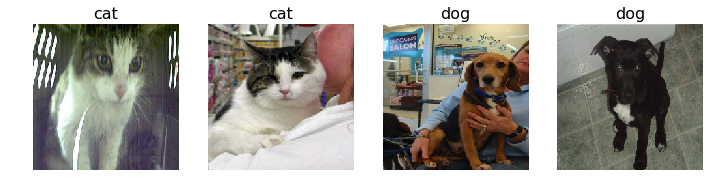

In [11]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs, labels = next(batches)

def generate_text_label(labels_arr):
    return ['cat' if label_arr[0] else 'dog' for label_arr in labels_arr]

plots(imgs, titles=generate_text_label(labels))

We now predict each batches. Prediction result from VGG16 model are 1000 probabilities for each image, representing probability that the model assigns to each possible imagenet category for each image. The category we returns for an image is it's category that has highest probability.

In [12]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print 'Preds shape: {}'.format(preds.shape)
    print 'First 5 classes: {}'.format(classes[:5])
    print 'First 5 probabilities: {}'.format(preds[0, :5])
    print 'Prediction prob/class: '
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print '  {:.4f}/{}'.format(preds[i, idx], classes[idx])
    

In [13]:
pred_batch(imgs)

Preds shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  9.2671e-06   4.4865e-06   1.6599e-04   1.6832e-05   3.0892e-05]
Prediction prob/class: 
  0.2375/llama
  0.1420/plastic_bag
  0.3322/Chihuahua
  0.1786/Boston_bull
